In [1]:
# 1: Install required libraries
# -----------------------------------------------------------

# Install the datasets library (Hugging Face datasets)
!pip install datasets --quiet

# Install additional libraries if needed
!pip install pandas numpy tensorflow scikit-learn --quiet

# -----------------------------------------------------------
# Import main libraries
# -----------------------------------------------------------
import pandas as pd
import numpy as np
import tensorflow as tf

from datasets import load_dataset

print("Setup complete!")


Setup complete!


In [2]:
# 2: Load 10% of Amazon Polarity dataset
from datasets import load_dataset

# Load 10% of Amazon reviews dataset
from datasets import load_dataset

dataset = load_dataset(
    "amazon_polarity",
    split="train[:2%]"
)

test_dataset = load_dataset(
    "amazon_polarity",
    split="test[:2%]"
)

print(dataset[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

amazon_polarity/train-00000-of-00004.par(…):   0%|          | 0.00/260M [00:00<?, ?B/s]

amazon_polarity/train-00001-of-00004.par(…):   0%|          | 0.00/258M [00:00<?, ?B/s]

amazon_polarity/train-00002-of-00004.par(…):   0%|          | 0.00/255M [00:00<?, ?B/s]

amazon_polarity/train-00003-of-00004.par(…):   0%|          | 0.00/254M [00:00<?, ?B/s]

amazon_polarity/test-00000-of-00001.parq(…):   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

{'label': 1, 'title': 'Stuning even for the non-gamer', 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'}


In [3]:
import pandas as pd

train_df = pd.DataFrame(dataset)
test_df = pd.DataFrame(test_dataset)

train_df.head()


,label,title,content
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,1,Amazing!,This soundtrack is my favorite music of all ti...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [4]:
# 3: Convert dataset into text and label lists
# ----------------------------------------------

#Extract text and labels from dataset
texts_train= [item['content']for item in dataset] #list of review
labels_train= [item['label']for item in dataset] #list of labels

texts_test= [item['content']for item in test_dataset]
labels_test= [item['label']for item in test_dataset]

#show a small sample
print('Sample text:', texts_train[0][:200]) #first 200 charss
print('Sample label:', labels_train[0])

print('Number of training samples:', len(texts_train))
print('Number of test samples:', len(texts_test))

Sample text: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I
Sample label: 1
Number of training samples: 72000
Number of test samples: 8000


In [52]:
# 4: Tokenize and pad sequences
#----------------------------------

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# 1: build the tokenizer
max_words = 20000

# Create a Tokenizer object
tokenizer = Tokenizer(num_words=max_words,  oov_token="<OOV>")  # <OOV> for unknown words

# Fit the tokenizer on the training data
tokenizer.fit_on_texts(texts_train)

import pickle

# حفظ الـ Tokenizer
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


# 2: convert text to sequences
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)
print('Sample sequence:', sequences_train[0][:20])

#3: pad sequences
maxlen= 150
X_train = pad_sequences(sequences_train, maxlen=maxlen, padding='pre')
X_test = pad_sequences(sequences_test, maxlen=maxlen, padding='pre')

#convert label
y_train = np.array(labels_train)
y_test = np.array(labels_test)

# 4: check shap
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)
#

Sample sequence: [9, 214, 502, 14, 409, 8, 5730, 2, 1, 11, 66, 400, 28, 67, 4, 43, 1607, 8, 70, 6]
Shape of X_train: (72000, 150)
Shape of y_train: (72000,)
Shape of X_test: (8000, 150)
Shape of y_test: (8000,)


In [53]:
# --------------------------
# 1️ Build the LSTM model
# --------------------------

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.utils import class_weight
import numpy as np

# Compute class weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Model parameters
embedding_dim = 128
input_length = maxlen  # padded sequence length

# Build the model
from tensorflow.keras.layers import Input

model = Sequential([
    Input(shape=(maxlen,)),  # shape of input sequences
    Embedding(input_dim=max_words, output_dim=embedding_dim),  # embedding layer
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dense(2, activation='sigmoid')
])


# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 150, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,609,538 (9.95 MB)

 Trainable params: 2,609,538 (9.95 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
from tensorflow.keras.callbacks import EarlyStopping

#  EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,            # stop training if val_loss doesn't improve for 2 epochs
    restore_best_weights=True
)

# Train the LSTM model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=3,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)

#save the model
model.save("sentiment_model.h5")

Epoch 1/3
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 338s 297ms/step - accuracy: 0.7620 - loss: 0.4781 - val_accuracy: 0.8618 - val_loss: 0.3261
Epoch 2/3
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 307s 272ms/step - accuracy: 0.8813 - loss: 0.2932 - val_accuracy: 0.8727 - val_loss: 0.3161
Epoch 3/3
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 357s 317ms/step - accuracy: 0.9098 - loss: 0.2291 - val_accuracy: 0.8637 - val_loss: 0.3301


In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f'test confusion: {confusion_matrix(y_test, np.argmax(model.predict(X_test), axis=1))}')
print(f'test classification report: {classification_report(y_test, np.argmax(model.predict(X_test), axis=1))}')

250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8684 - loss: 0.3185
Test Loss: 0.31609946489334106
Test Accuracy: 0.8727499842643738
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step
test confusion: [[3523  397]
 [ 621 3459]]
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step
test classification report:               precision    recall  f1-score   support

           0       0.85      0.90      0.87      3920
           1       0.90      0.85      0.87      4080

    accuracy                           0.87      8000
   macro avg       0.87      0.87      0.87      8000
weighted avg       0.87      0.87      0.87      8000



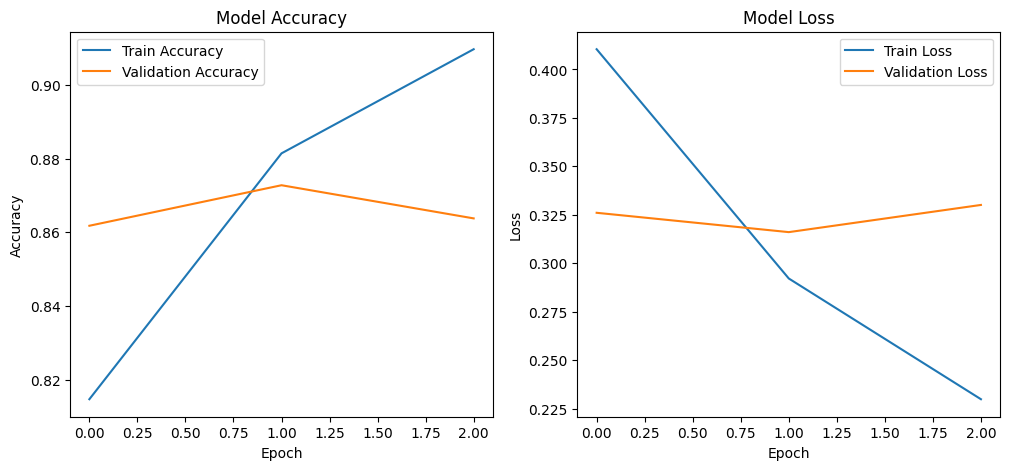

In [56]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [57]:
# Function to predict sentiment for a new review
def predict_review(text):
    # Tokenize the input text
    seq = tokenizer.texts_to_sequences([text])
    # Pad the sequence
    padded = pad_sequences(seq, maxlen=maxlen, padding='pre')
    # Predict
    pred = model.predict(padded)
    # Convert probability to class label
    label = np.argmax(pred)  # 0 = negative, 1 = positive
    sentiment = 'Positive' if label == 1 else 'Negative'
    print(f"Review: {text}")
    print(f"Predicted Sentiment: {sentiment}")

# Example
predict_review("I love this product! It works perfectly and I am very happy.")
predict_review("This is the worst purchase I have ever made.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
Review: I love this product! It works perfectly and I am very happy.
Predicted Sentiment: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Review: This is the worst purchase I have ever made.
Predicted Sentiment: Negative


In [58]:
predict_review("I feel hopeful about what’s coming next.")
predict_review("I’m really frustrated with everything right now.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Review: I feel hopeful about what’s coming next.
Predicted Sentiment: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Review: I’m really frustrated with everything right now.
Predicted Sentiment: Negative


In [59]:
# Install Streamlit and pyngrok
!pip install streamlit
!pip install pyngrok


In [106]:
# Create a Python file for Streamlit app
# ===============================
# Amazon Reviews Sentiment Analysis
# ===============================
%%writefile app.py
import streamlit as st
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1️ Load Tokenizer & Models
# -------------------------------
with open("tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)

lstm_model = tf.keras.models.load_model("sentiment_model.h5")
#gru_model = tf.keras.models.load_model("gru_model.h5")
maxlen = 100  # same as training

# -------------------------------
# 2️ Page config & custom styling
# -------------------------------
st.set_page_config(
    page_title="Amazon Reviews Sentiment Analysis",
    page_icon="🛒",
    layout="wide",
    initial_sidebar_state="expanded"
)

st.markdown("""
<style>
.main {background-color: #f0f2f6; color: #333; font-family: 'Segoe UI', sans-serif;}
.stButton>button {background-color: #4CAF50; color: white; font-size: 18px; border-radius: 8px; padding: 10px 20px;}
.stTextArea>textarea {font-size: 16px;}
</style>
""", unsafe_allow_html=True)

# -------------------------------
# 3️ Sidebar
# -------------------------------
st.sidebar.title("Options")
st.sidebar.info("""
- Choose the model: LSTM or GRU
- Enter multiple reviews separated by line breaks
- Click Predict to see results
""")

model_choice = st.sidebar.radio("Select Model:", ["LSTM", "GRU"])

# -------------------------------
# 4️ Main UI
# -------------------------------
st.title("🛒 Amazon Reviews Sentiment Analysis")
st.subheader("Detect Positive or Negative reviews using Deep Learning")

user_input = st.text_area("Enter Amazon reviews (one per line):", height=200)

# -------------------------------
# 5️ Prediction
# -------------------------------
if st.button("Predict Sentiment"):
    if user_input.strip() == "":
        st.warning("Please enter at least one review!")
    else:
        # Split reviews by lines
        reviews = [r.strip() for r in user_input.strip().split("\n") if r.strip()]
        sequences = tokenizer.texts_to_sequences(reviews)
        padded = pad_sequences(sequences, maxlen=maxlen, padding='pre')

        # Choose model
        model = lstm_model if model_choice == "LSTM" else gru_model

        preds = model.predict(padded)
        sentiments = ["Positive" if p.argmax() == 1 else "Negative" for p in preds]
        confidences = [p.max()*100 for p in preds]

        # Display results in a dataframe
        df = pd.DataFrame({
            "Review": reviews,
            "Sentiment": sentiments,
            "Confidence (%)": confidences
        })
        st.table(df)

        # Optional: plot bar chart of Positive vs Negative
        counts = df['Sentiment'].value_counts()
        fig, ax = plt.subplots()
        counts.plot(kind='bar', color=['#4CAF50','#FF5252'], ax=ax)
        ax.set_title("Sentiment Distribution")
        ax.set_ylabel("Number of Reviews")
        st.pyplot(fig)





Writing app.py


In [107]:
!is

/bin/bash: line 1: is: command not found


In [108]:
!pip install streamlit pyngrok --quiet

In [137]:
import os
from pyngrok import ngrok


ngrok_token = os.getenv("NGROK_TOKEN")
ngrok.set_auth_token(ngrok_token)



In [141]:
public_url = ngrok.connect()
public_url


<NgrokTunnel: "https://annalise-transiliac-unpaternally.ngrok-free.dev" -> "http://localhost:80">

In [139]:
!nohup streamlit run app.py > streamlit.log 2>&1 &


In [133]:
!tail -f streamlit.log


Usage: streamlit run [OPTIONS] [TARGET] [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: professional_app.py
^C


In [134]:
!pkill ngrok


In [135]:
!pkill streamlit

In [136]:
!ps -ef | grep ngrok
!ps -ef | grep streamlit


root       76592     282  0 16:45 ?        00:00:00 /bin/bash -c ps -ef | grep ngrok
root       76594   76592  0 16:45 ?        00:00:00 grep ngrok
root       76595     282  0 16:45 ?        00:00:00 /bin/bash -c ps -ef | grep streamlit
root       76597   76595  0 16:45 ?        00:00:00 grep streamlit


In [140]:
# ===============================
# Colab: Download entire project as zip
# ===============================

from google.colab import files
import os

#
project_files = [
    "app.py",  #streamlit file
    "sentiment_model.h5",        #LSTM
    "logs.txt",
    "streamlit.log",

    "tokenizer.pickle"      # Tokenizer
    #
]

# zip file
zip_filename = "amazon_project.zip"

# zip
files_to_zip = " ".join(project_files)  #
os.system(f"zip -r {zip_filename} {files_to_zip}")

#
files.download(zip_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>